## Интеллектуальный анализ данных – весна 2024
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать со встроенным в `sklearn` набором данных `wine`, содержащим информацию о характеристиках трёх видов вина. Описание набора можно найти [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) и [здесь](https://rdrr.io/cran/rattle.data/man/wine.html).

Загрузим набор данных и сохраним информацию о признаках в переменную `X`, а о зависимой переменной – в переменную `y`.

In [275]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [276]:
from sklearn.datasets import load_wine

data = load_wine()
X = pd.DataFrame(data['data'], columns = data['feature_names'])
y = pd.DataFrame(data['target'])
X.head(8)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0


**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные переменные? Если да, то закодируйте их при помощи OneHot-кодирования. Используйте [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

In [277]:
X.isnull().sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64

В наборе не пропущенных значений

In [279]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse_output=False).set_output(transform='pandas')
ohetransform = ohe.fit_transform(y)


**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

Используйте аргумент `stratify` при разбиении. Почему это важно?

In [280]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.3, shuffle=True, random_state=0, stratify=y
)

Использовать stratify необходимо, для того чтобы сохранить баланс классов в тренировочной и тестовой выборках

**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака: `alcohol` и `magnesium` – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [281]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [282]:

X_train_subset = X_train[['alcohol', 'magnesium']]
X_test_subset = X_test[['alcohol', 'magnesium']]


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_subset)
X_test_scaled = scaler.transform(X_test_subset)


neighbors = [1, 3, 5, 10, 15, 25]
print('NN train test')
for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaled, y_train)
    train_pred = knn.predict(X_train_scaled)
    test_pred = knn.predict(X_test_scaled)
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)
    print(f'{i} {train_accuracy:.2f} {test_accuracy:.2f}')


NN train test
1 0.99 0.72
3 0.80 0.74
5 0.77 0.76
10 0.78 0.78
15 0.73 0.72
25 0.72 0.74


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/).

In [283]:
!pip install mlxtend

Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [284]:
import mlxtend

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов.
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново.
6. Построение графика может занять некоторое время – придётся немного подождать!

In [285]:
y1 = y_train.values.flatten()
y1

array([2, 0, 0, 0, 2, 1, 1, 2, 1, 1, 1, 0, 1, 2, 0, 2, 1, 0, 2, 2, 1, 0,
       1, 1, 1, 1, 2, 0, 1, 1, 0, 0, 2, 0, 1, 0, 0, 1, 2, 2, 0, 2, 2, 2,
       0, 1, 2, 2, 1, 2, 1, 1, 1, 0, 1, 1, 2, 2, 1, 0, 0, 1, 2, 2, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 2, 0, 1, 2, 1, 1, 2, 0, 1, 0, 1, 1, 2, 1,
       0, 0, 0, 2, 1, 0, 0, 1, 1, 2, 2, 1, 0, 0, 1, 1, 2, 0, 2, 0, 1, 1,
       1, 1, 0, 2, 0, 0, 0, 0, 1, 1, 2, 2, 1, 1])

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

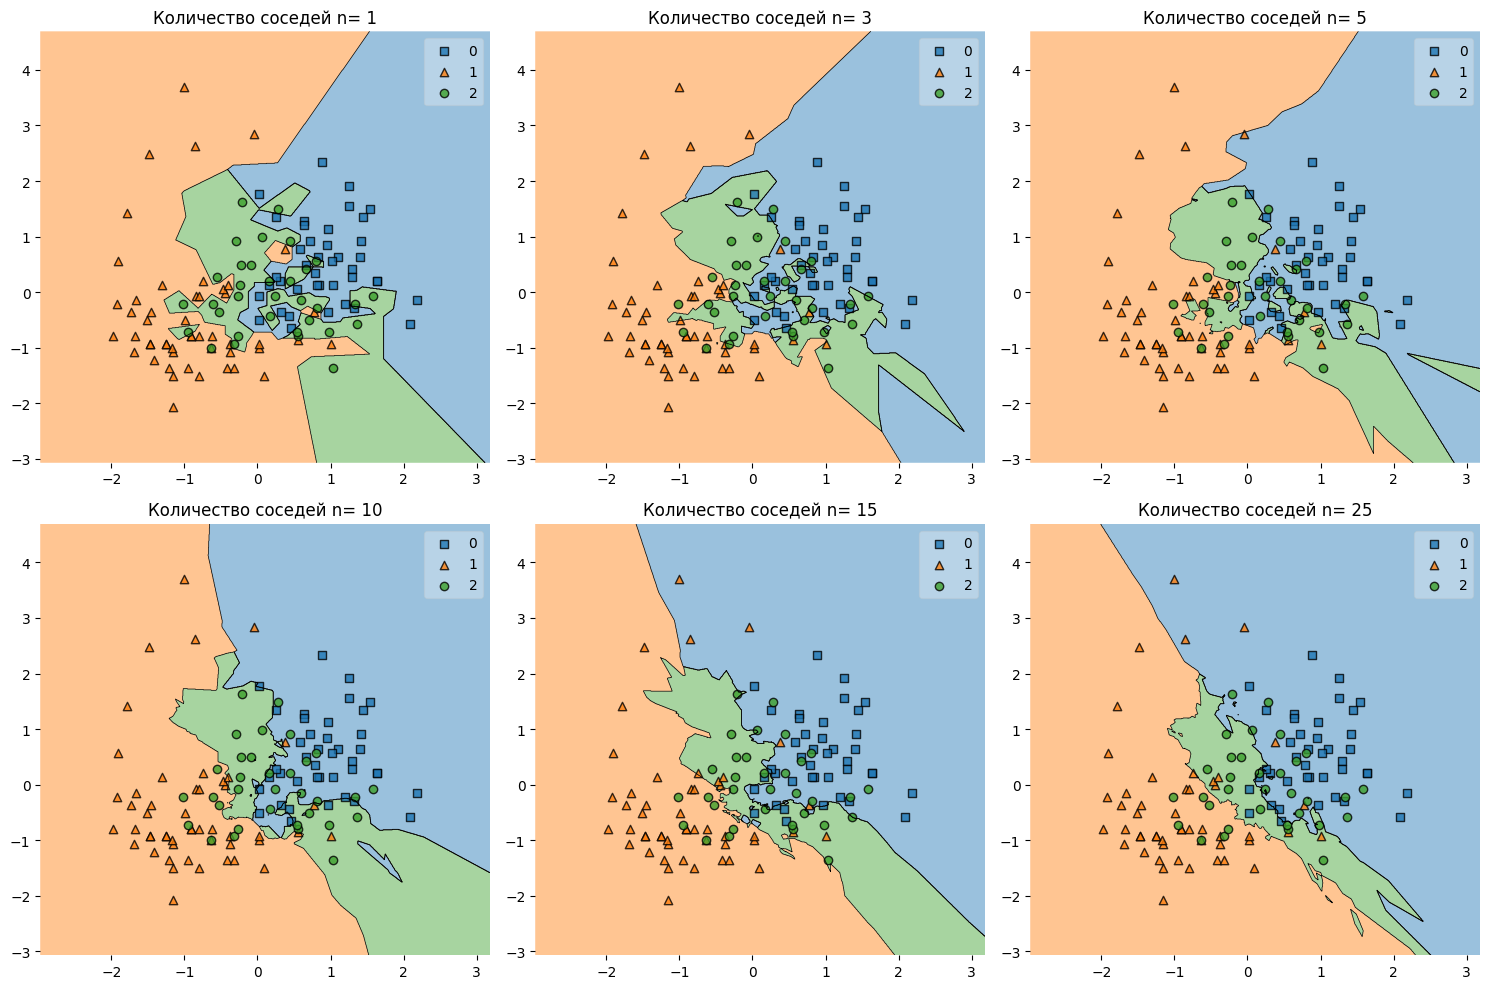

In [286]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import itertools

fig, axs = plt.subplots(2, 3, figsize=(15, 10))


classifiers = [KNeighborsClassifier(n_neighbors=n) for n in [1, 3, 5, 10, 15, 25]]
for clf, axx, ax, nn in zip(classifiers, axs.flatten(), itertools.product([0, 1], [0, 1, 2]), [1, 3, 5, 10, 15, 25]):
    clf.fit(X_train_scaled, y_train)
    plot_decision_regions(X_train_scaled, y1, clf=clf, ax=axs[ax[0], ax[1]])
    axx.set_title(f'Количество соседей n= {nn}')

plt.tight_layout()
plt.show()




**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности. Какие из результатов явно говорят о переобучении модели? Почему?

Для обучения оптимальней всего использовать k = 10. Это объяняется тем, что на тренровочной и на тестовой выборках результат оказался одинаковый(понятно, что это случайность из-за рандомной разбивки данных), также это подтверждается решающими плоскостями. Если посмотреть на получившуюся плоскость при k = 1, то мы увидим, что модель очень чувствительна к различным выбросам и шумам, котрые присутствуют в данных. При увеличении k ситуация меняется к лучшему, но все еще видна сильная чувствительность. Если посмотреть на решающие плоскости при k = 15 и k = 25, то можно заметить, что модель наоборот перестает реагировать на выбросы и перестает быть гибкой, что тоже не есть хорошо для классификации. Следовательно идеальный вариант значения k = 10.

Явно о переобучении говорят модели с значением k = [1, 3]. Это объяняется тем, что модель при таких значениях k очень чувствительная к выбросам и шумам в данных. То есть при классификации объекта не будет учитываться распределение объектов вокруг, а будет учитываься только 1 самый ближайший. С k = 3 такая же ситуация.

### Задание 2. KNN своими руками. 2 Балла

В данном задании мы попробуем реализовать алгоритм KNN своими руками. В данном случае мы попробуем сделать KNN для классификации.

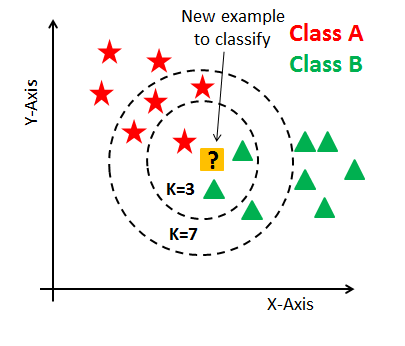

In [287]:
import numpy as np
from collections import Counter
from numpy. linalg import norm

class KNN:
    def __init__(self, k:int):
        self.k = k

    def fit(self, X, y):
      self.X = X
      self.y = y

    def predict(self, X):
      res = []
      for x in X:
        nearest_k = np.argsort([self.count_distance(x, xself) for xself in self.X])[:self.k]
        nearest_classes = [self.y[i] for i in nearest_k]
        res.append(Counter(nearest_classes).most_common(1)[0][0])
      return np.array(res)

    def count_distance(self, x, y):
      return norm(x-y)


In [288]:
# Не меняйте файл!
def test_knn(KNN):
  knn = KNN(k=1)
  X_train =  np.array([[1, 1], [2, 2]])
  y_train =  np.array([0, 1])
  X_test =  np.array([[1.5, 1.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [0]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[9.5, 9.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5.5, 5.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[15, 15]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5, 5], [2, 2]])
  knn.fit(X_train, y_train)
  assert all(knn.predict(X_test) == [1, 0])

In [289]:
# Если тесты эти пройдены, то все верно!
test_knn(KNN)

### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [290]:
from sklearn.preprocessing import StandardScaler
data = pd.read_csv('diamonds.csv')
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.2 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их.
Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

In [291]:
data.isna().sum()

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

In [292]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


Пропущенных значений в dataframe нет.

In [293]:
data = data.drop(["Unnamed: 0"], axis=1)
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


**Задача 3.2 (0.1 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Выведите матрицу выборочных корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки коррелируют с целевой переменной больше всего?

In [294]:
data.corr()

<ipython-input-294-c44ded798807>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,carat,depth,table,price,x,y,z
carat,1.000000,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387
depth,0.028224,1.000000,-0.295779,-0.010647,-0.025289,-0.029341,0.094924
table,0.181618,-0.295779,1.000000,0.127134,0.195344,0.183760,0.150929
price,0.921591,-0.010647,0.127134,1.000000,0.884435,0.865421,0.861249
x,0.975094,-0.025289,0.195344,0.884435,1.000000,0.974701,0.970772
y,0.951722,-0.029341,0.183760,0.865421,0.974701,1.000000,0.952006
z,0.953387,0.094924,0.150929,0.861249,0.970772,0.952006,1.000000


Больше свего с целевой переменной коррелируют [carat, x, y, z].

Совсем незначительную и даже отрицательную корреляцию показывают признаки [depth, table]

**Задача 3.3 (0.1 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные переменные при помощи OneHot-кодирования.

In [295]:
s = (data.dtypes == "object")
object_cols = list(s[s].index)
print(object_cols)
data

['cut', 'color', 'clarity']


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


In [296]:
from sklearn.preprocessing import OneHotEncoder
ohe_data = data.copy()
res = data.copy()
ohe_encoder = OneHotEncoder(handle_unknown = 'ignore', sparse_output=False).set_output(transform='pandas')
for i in object_cols:
  ohe_data = ohe_encoder.fit_transform(pd.DataFrame(res[i]))
  res = pd.concat([res, ohe_data], axis = 1)
  res = res.drop(i, axis=1)
res

,carat,depth,table,price,x,y,z,cut_Fair,cut_Good,cut_Ideal,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.72,60.8,57.0,2757,5.75,5.76,3.50,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
53936,0.72,63.1,55.0,2757,5.69,5.75,3.61,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
53937,0.70,62.8,60.0,2757,5.66,5.68,3.56,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
53938,0.86,61.0,58.0,2757,6.15,6.12,3.74,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


**Задача 3.4 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3. Не забудьте про параметр `stratify`.

In [297]:
from sklearn.model_selection import train_test_split
y_ohe = data["price"]
X_ohe = data.drop(["price", 'cut', 'color', 'clarity'], axis=1)
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(
    X_ohe, y_ohe, test_size=0.3, shuffle=True, random_state=0
)

**Задача 3.5 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче масштабируйте вещественные признаки тренировочной и тестовой выборок при помощи модуля `StandardScaler`.

In [298]:
scaler = StandardScaler()
X_train_ohe = scaler.fit_transform(pd.DataFrame(X_train_ohe))
X_test_ohe = scaler.transform(pd.DataFrame(X_test_ohe))

**Задача 3.6 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [299]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


model = LinearRegression()
model.fit(X_train_ohe, y_train_ohe)
y_train_pred = model.predict(X_train_ohe)
train_mse = mean_squared_error(y_train_ohe, y_train_pred)
y_test_pred = model.predict(X_test_ohe)
test_mse = mean_squared_error(y_test_ohe, y_test_pred)
print(f'MSE: {train_mse}')
print(f'MSE: {test_mse}')


MSE: 2253603.727003835
MSE: 2211578.0094714533


**Задача 3.7 (0.2 балла)** Изучите [документацию](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [300]:
coefficients = model.coef_
features = X_ohe.columns

for feature, coef in zip(features, coefficients):
    print(f'{feature}: {coef}')


carat: 5008.750314557028
depth: -286.88380581415265
table: -238.82867285016385
x: -1369.1638704735567
y: 41.11911937026491
z: 13.523583109804349


**Задача 3.8 (0.4 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом.

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \frac{1}{2}\alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией.

Обучите Lasso-регрессию и Ridge-регрессию, уставновив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [301]:
from sklearn.linear_model import Lasso

lass = Lasso()
lass.fit(X_train_ohe, y_train_ohe)
features = X_ohe.columns
for feature, coef in zip(features, lass.coef_):
    print(f'{feature}: {coef}')


carat: 4966.038597723583
depth: -281.79468037023304
table: -237.6014492484061
x: -1289.0727747903845
y: 15.695829108952264
z: -0.0


In [302]:
from sklearn.linear_model import Ridge

rid = Ridge()
rid.fit(X_train_ohe, y_train_ohe)
features = X_ohe.columns
for feature, coef in zip(features, rid.coef_):
    print(f'{feature}: {coef}')

carat: 5005.196095711134
depth: -286.6192118393817
table: -238.80850390054883
x: -1364.7852164923663
y: 40.77099810948046
z: 12.96411351390947


**Задача 3.9 (0.4 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов.

Какой метод агрессивнее уменьшает веса? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

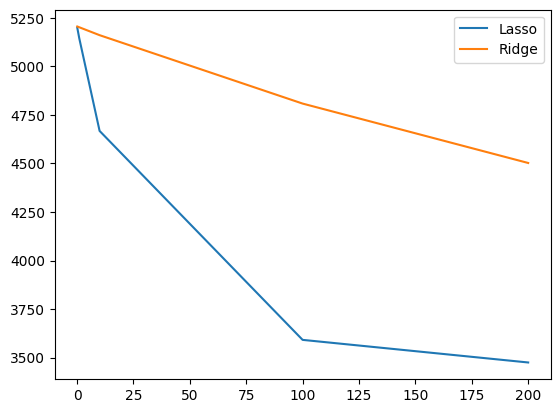

In [303]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge

coef = [0.1, 1, 10, 100, 200]
larr = []
rarr = []


for i in coef:
  lass = Lasso(alpha=i)
  lass.fit(X_train_ohe, y_train_ohe)
  larr.append(np.linalg.norm(lass.coef_))

  rid = Ridge(alpha=i)
  rid.fit(X_train_ohe, y_train_ohe)
  rarr.append(np.linalg.norm(rid.coef_))

plt.plot(coef, larr, label='Lasso')
plt.plot(coef, rarr, label='Ridge')
plt.legend()


**Задача 3.10 (0.5 балла)**
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке.

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`.

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество.

In [304]:
from sklearn.linear_model import LassoCV

alphas = [0.1, 1, 10, 100, 200]
lasso_cv = LassoCV(alphas = alphas, cv = 5)

lasso_cv.fit(X_train_ohe, y_train_ohe)

table = lasso_cv.mse_path_
table_mean = np.mean(table, axis=1)
best_mse = np.argmin(table_mean)
best_alpha = lasso_cv.alphas_[best_mse]
print(f'Лучшая aplha = {best_alpha}')

Лучшая aplha = 10.0


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 194865161.8812561, tolerance: 48309472.87280814
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2826992286.616852, tolerance: 48309472.87280814
  model = cd_fast.enet_coordinate_descent_gram(


**Задача 3.11 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [305]:
lasso = Lasso(alpha = 10.0)
lasso.fit(X_train_ohe, y_train_ohe)

coef = lasso.coef_
features = X_ohe.columns

for feature, cf in zip(features, coef):
  print(f'{feature}: {cf}')

carat: 4571.294441762419
depth: -248.032088789469
table: -223.81320308904805
x: -881.980900783243
y: -0.0
z: -0.0


Информативными являются такие признаи, как [carat, depth, table, x].
Неинформативными являются оставшиеся признаки.
Carat является информативным, поскольку чем тяжелее бриллиант, тем он дороже.
Также информативным является параметр "х", то есть длина бриллианта. Это очевидно, поскольку длинные бриллианты ценятся, но не слишком длинные.
Все информативные каким-то образом влияют на ценообразование бриллианта, в то время как остальные не влияют на нее

**Задача 3.12 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

In [306]:
from sklearn.metrics import mean_absolute_error

y_pred = lasso.predict(X_test_ohe)
print(f'MSE: {mean_absolute_error(y_test_ohe, y_pred)}')

MSE: 914.3766961692374


Значение MSE в задаче 3.7 на тестовой выборке MSE: 2211578.0094714533, а знаечние MSE используя L1 регуляризацию равно MSE: 914.3766961692374. Из этого можно сделать логический вывод, что модель с L1 регуляризацией использовать лучше.

Поскольку модель без L1 регуляризации учитывает все признаки даже не особо информативные, то именно они и могут путать модель и мешать ей делать правильные предсказания. А в случае модели с L1 регулярищацией мы как раз не учитывем неинформативные признаки, что позволяет более точно предсказывать целевую переменную и дополнительно избегать переобучения

